<a href="https://colab.research.google.com/github/wornSweater/Deep-Learning-Class/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab 2**

TI3155TU Deep Learning (2023 - 2024)

Authors: Jan Warchocki, Elena Congeduti

Revision: Karol Dobiczek

# Instructions
We highly recommend to work at these labs on Google Colab by saving a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`) or on Kaggle by downloading this lab as .ipynb file (`File` $\rightarrow$ `Download .ipynb`) and import it into a new Kaggle Notebook.

To work locally, you need to download the lab and configure your virtual environment.

Check the [Lab Instructions](https://brightspace.tudelft.nl/d2l/common/dialogs/quickLink/quickLink.d2l?ou={orgUnitId}&type=content&rcode=tudelft-1344559Instructions) on Brightspace for detailed information on Kaggle set up and virtual environment configuration for local exectuion.

These labs include programming exercises and insight questions.

Follow the instructions in the notebook: fill in the text blocks to answer the questions and write your own code to solve the programming tasks within the designated part of the code blocks:
```python
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################


#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Solutions will be shared one week after the labs are published.

Note that these labs are designed for practice and are therefore **ungraded**.

**For these labs, you can use only basic tensor operators from the `torch` module unless otherwise specified. Therefore avoid using `torch.nn.F`, `torch.nn.Sequential` or other advanced modules.**

In [ ]:
# Setup
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
import torch.nn as nn
import torch.optim as optim

from scipy.stats import multivariate_normal


# 1 Backpropagation

In the previous lab, we learned how to train a neural network when the parameters are sampled randomly. In this lab, we will complete the training loop by incoporating the *backpropagation* algorithm to optimize the parameter selection.

## 1.1 Computing gradients with computation graphs

The **chain rule** gives us an easy way to compute derivatives of complex functions. Given a function $f(x) = h_n(\ldots (h_2(h_1(x)))$, we can compute the derivative $\frac{\partial f}{\partial x}$ as:

$$
\frac{\partial f}{\partial x} = \frac{\partial f}{\partial h_n}  \cdot \ldots \cdot \frac{\partial h_2}{\partial h_1}\frac{\partial h_1}{\partial x}
$$

Remember that the chain rule also applies to functions of multiple variables $f(x)=f(h_1(x),h_2(x))$ as
$$
\frac{\partial f}{\partial x} = \frac{\partial f}{\partial h_1}\frac{\partial h_1}{\partial x}+\frac{\partial f}{\partial h_2}\frac{\partial h_2}{\partial x}
$$

Now, we can apply the chain rule to a simple neural network. Consider the example below, where all the units use a sigmoid activation function

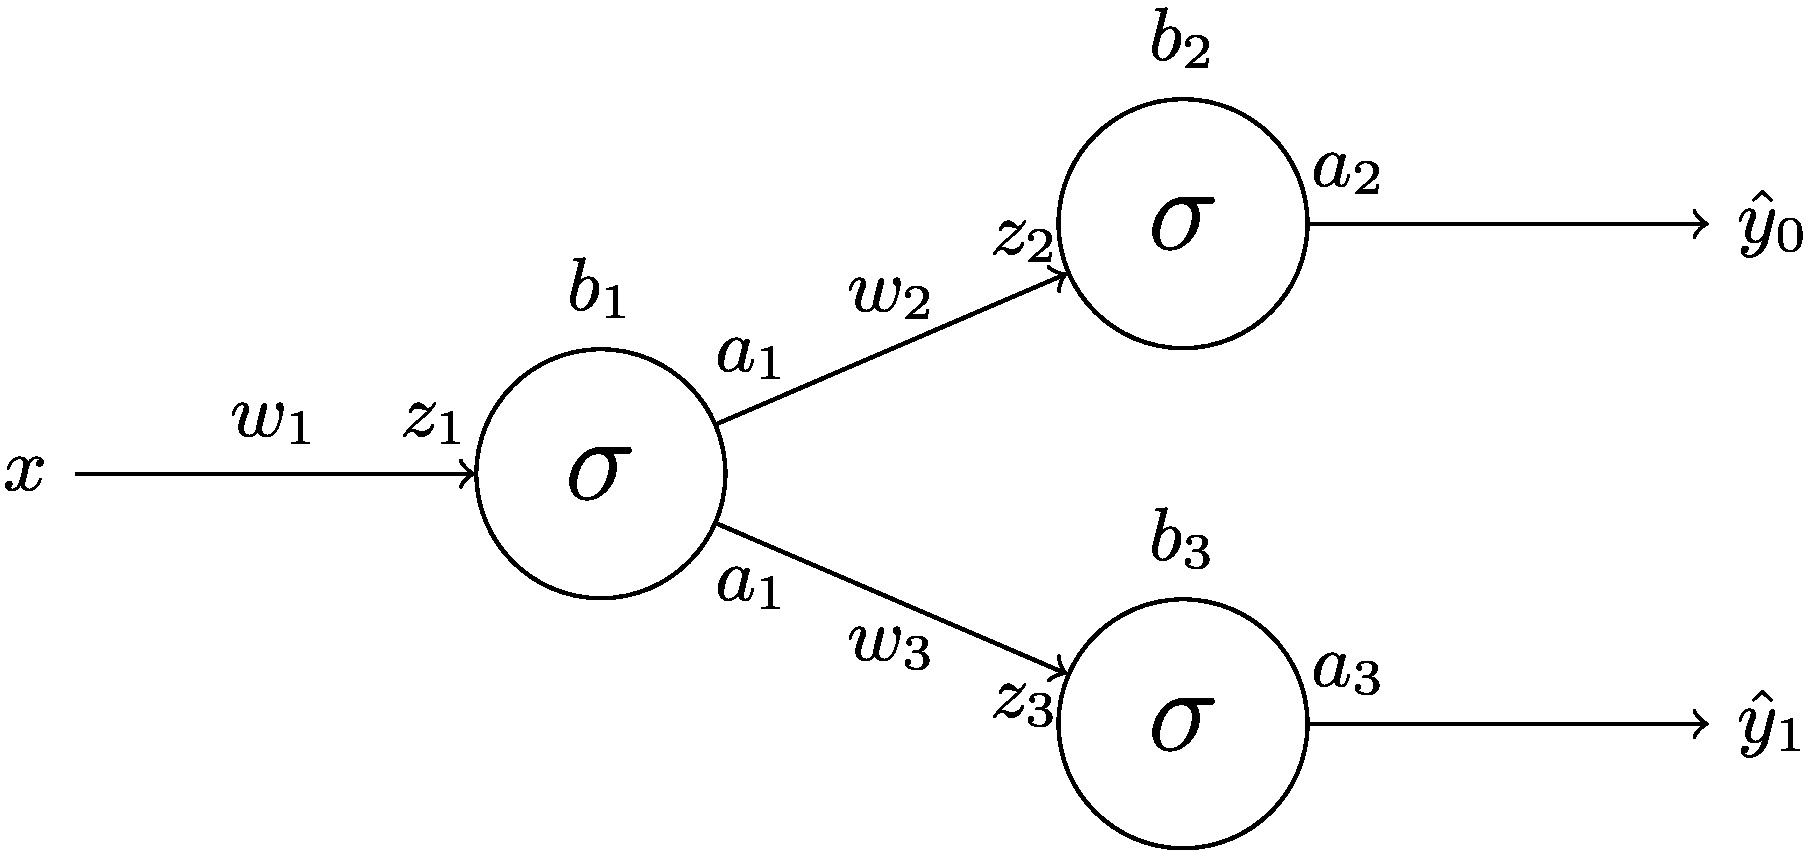

The following equations describe the forward pass

$$
\begin{align}
z_1 &=w_1 x+b_1\\
a_1 &= \sigma(z_1)\\
z_2 &=w_2 a_1+b_2\\
z_3 &=w_3 a_1+b_3\\
a_2 &=\sigma(z_2)\\
a_3 &=\sigma(z_3)\\
\hat y_0 &=a_2\\
\hat y_1 &=a_3
\end{align}
$$

We want to compute the derivatives with respect to the network parameters of the mean squared error $L$
$$
L = \frac{1}{2}(y_0 - \hat{y}_0)^2 + \frac{1}{2}(y_1 - \hat{y}_1)^2
$$

****
**Question 1.1:** Write down the chain rule to compute the derivative $\frac{\partial L}{\partial w_1}$. How many more derivatives do we need to compute to obain the derivative with respect to $b_1$ and $w_2$, $\frac{\partial L}{\partial b_1}$, $\frac{\partial L}{\partial w_2}$? Thus, what is the total number of derivatives to compute for backpropagation in this network?

<font color='green'> Write your answer here <font>
****

To become familiar with the concept of a computation graph, we will build one for the following loss function
$$
L = \left ( y - \text{ReLU}(w_2(\text{ReLU}(w_1x+b_1))+b_2) \right )^2
$$
for input and output $x,y\in\mathbb{R}$.

First we initialize tensors $W=[w_1,w_2]$ and $b=[b_1,b_2]$ for the network parameters. To use automatic PyTorch functionalities to compute gradients we will need to specify that those tensors require gradients.

In [ ]:
#Dummy weights initialization
W = torch.ones(2,dtype=torch.float32, requires_grad=True)
print('W',W)

#Dummy bias initialization
b = torch.ones(2,dtype=torch.float32, requires_grad=True)
print('b',b)

W tensor([1., 1.], requires_grad=True)
b tensor([1., 1.], requires_grad=True)


****
**Task 1.2:**
Write down the forward pass equations for the network  by decomposing the loss function in multiple steps computing progressively ```z1```, ```a1```, ```z2```, ```a2```. Test the equations on a dummy batch sample $x$ to obtain the output $\hat y=a_2$. Then add the step to compute the loss assuming dummy labels $y$.
****

In [ ]:
#Batch sample
x = torch.arange(5)

#Batch labels
y = torch.arange(5)

print('Dummy batch ', x)
print('Dummy labels ', y)

relu = nn.ReLU()

#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
z1 = W[0]*x + b[0]
a1 = relu.forward(z1)
z2 = W[1]*a1 + b[1]
a2 = relu.forward(z2)
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

#Print the last layer pre-activation values
print('\nPre-activations z2 ', z2)

#Network output corresponds to last network activation
hat_y = a2
print('\nForward pass output ', hat_y)

#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
loss = torch.mean((hat_y-y)**2)
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

print('\nLoss ', loss)


Dummy batch  tensor([0, 1, 2, 3, 4])
Dummy labels  tensor([0, 1, 2, 3, 4])

Pre-activations z2  tensor([2., 3., 4., 5., 6.], grad_fn=<AddBackward0>)

Forward pass output  tensor([2., 3., 4., 5., 6.], grad_fn=<ReluBackward0>)

Loss  tensor(4., grad_fn=<MeanBackward0>)


****
**Question 1.3:**
Depict the computation graph associated to this network.
****

In this way we have constructed a computation graph. Each node of the computation graph has automatically defined a function `grad_fn` for calculating the gradient with respect to its inputs. You can observe this when we print the pre-activation tensor $z_2$, the activation $a_2$ and the `loss`.

We can perform backpropagation on the computation graph by calling the function `backward()` on the last output which corresponds to the loss. Such function calculates the gradients for each tensor on the computation graph that has the property `requires_grad=True`.

In [ ]:
#Compute the computation graph derivatives
loss.backward()

Each tensor in the forward pass has now attached the corresponding gradient as the tensor attribute `.grad`.

Note that if you run the previous cell multiple times without resetting to zero the gradients (using `parameters.grad.zero_()`) the gradients will accumulate with each run.

****
**Question 1.4:**
Compute the derivatives $\frac{\partial L}{\partial b_2}$ for the dummy batch $x$ and labels $y$. Verify your result by printing the corresponding component of `b.grad`.


<font color='green'>Write your answere here</font>
****

In [ ]:
print(b.grad[1])

tensor(4.)


## 1.2 Update step

Once we have computed the gradient for the batch input, we update the parameters by taking one step in the direction of maximum steepness of the loss function. The update rules for weights and biases are as follows

$$
w' = w - \alpha \frac{\partial L}{\partial w} \hspace{20pt} b' = b - \alpha \frac{\partial L}{\partial b}
$$

for learning rate $\alpha$, which regulates the magnitude of the step.



****
**Task 1.5:** Compute the update step for $b$ for the dummy batch $x$ assuming $\alpha=0.1$.
****

In [ ]:
#Set learning rate
alpha = 0.1

#Initial bias b2
print('Initial b2 ', b[1].detach())

#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
b = b - alpha*b.grad
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################


#Updated bias b2
print('Updated b2 ', b[1].detach())

Initial b2  tensor(1.)
Updated b2  tensor(0.6000)


****
**Question 1.6:**
Verify your outcome of the previous task by computing with pen and paper the update step for $b_2$.


<font color='green'>Write your answere here</font>
****

# 2 Backward pass
Here we will work at our own implementation of the backward pass for mini-batch gradient descent. The input is a batch matrix $x$ of shape $M \times N_\text{in}$ with $M$ being the size of the batch (number of training examples in the batch) and $N_\text{in}$ being the number of features or dimensions of each training example. The output of the network is a tensor $y$ of shape $M \times N_\text{out}$ with $N_\text{out}$ being the number of features or dimensions of the output.

To perform the backward pass, we need to ensure that the gradients are computed by using the chain rule as explained in the previous sections. That is, for every parent node in the computation graph, we are reusing the derivatives already computed for child nodes.
As an example, let us have a look at the derivatives of two consecutive nodes in the computation graph introduced in the previous section

$$
\begin{align}
\frac{\partial L}{\partial z_2} &=  \frac{\partial L}{\partial a_2} \frac{\partial a_2}{\partial z_2}  = 2(\hat{y} - y)\mathbb{1}(z_2\geq 0) \\
\frac{\partial L}{\partial a_1} &= \left ( \frac{\partial L}{\partial a_2} \frac{\partial a_2}{\partial z_2} \right ) \frac{\partial z_2}{\partial a_1} = \left ( 2(\hat{y} - y)\mathbb{1}(z_2\geq 0) \right ) w_2
\end{align}
$$

Therefore, parent nodes in the computation graph reuse gradients from child nodes. In this case, the derivative $\frac{\partial L}{\partial z_2} = 2(\hat{y} - y)\mathbb{1}(z_2\geq 0)$ is (re)used to compute $\frac{\partial L}{\partial a_1}$. Note that for deeper networks, the shared component would be much larger.

We call the gradient of the child node, the *upstream* gradient. During backpropagation, a layer takes as input the upstream gradient from the deeper (child) layer ($\frac{\partial L}{\partial z_2}$) to compute and store the *local gradients* ($\frac{\partial L}{\partial w_2}=\frac{\partial L}{\partial z_2}a_1$, $\frac{\partial L}{\partial b_2}=\frac{\partial L}{\partial z_2}$) and to produce as output the *downstream* gradient ($\frac{\partial L}{\partial a_1}$) which is *upstreamed* to the subsequent (parent) layer.



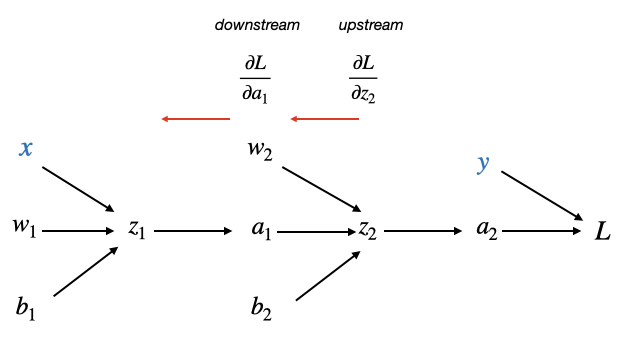

Note that computing the gradients for a given layer requires some values from the forward pass ($a_1$ in the above example). We will need therefore to store them during the forward pass.

We will build the backward pass algorithm for the network class starting from single layers.

## 2.1 Linear layer
Let us start from a simple linear layer. We assume that the input to the linear layer is the activation $a\in\mathbb{R}^{M\times N_\text{in}}$ and the output is the pre-activation $z\in\mathbb{R}^{M\times N_\text{out}}$, i.e. $z=aw+b$ for $w\in\mathbb{R}^{N_\text{in}\times {N_\text{out}}}$ and $b\in\mathbb{R}^{N_\text{out}}$.

****
**Question 2.1:**
What are the input and output of the backward method for the linear layer? Specify the dimensions.

<font color='green'>Write your answere here</font>
****

****
**Task 2.2:** Fill out the `forward` method to store the input in the variable `cache`. Then complete the `backward` method with the computation of the downstream gradient.
****

In [ ]:
class Linear(object):

    """
    Fully connected layer.

    Args:
      N_in:  number of input features (input space dimension)
      N_out: number of output features (output space dimension)
    """

    def __init__(self, N_in, N_out):

      #Define tensors for weights and bias
      self.weight = torch.Tensor(N_in, N_out)
      self.bias = torch.Tensor(N_out)

      self.init_params()

      #Define a cache varible to store the layer input
      self.cache = None

      #Define variables to store the gradients of the weight and bias
      self.weight_gradients = None
      self.bias_gradients = None

    def init_params(self):
        """
        Initialize layer parameters by sampling from uniform distribution over [0,1)
        """
        self.weight = torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)


    def forward(self, a):

        z = torch.matmul(a, self.weight) + self.bias

        ########################################################################
        #                        START OF YOUR CODE                            #
        ########################################################################
        self.cache = a
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return z

    def backward(self, upstream):
      """
      Backward pass of linear layer: calculate gradients of loss with respect
      to weight and bias and return downstream gradient.

      Args:
          upstream: gradient of loss with respect to output z

      Returns:
          downstream: gradient of loss with respect to input a
      """

      ########################################################################
      #                        START OF YOUR CODE                            #
      ########################################################################
      a = self.cache
      downstream = torch.matmul(upstream, self.weight.T)
      ########################################################################
      #                         END OF YOUR CODE                             #
      ########################################################################

      self.weight_gradients = torch.matmul(a.T,upstream)
      self.bias_gradients = torch.sum(upstream,dim=0)

      return downstream


****
**Question 2.3:**
What are we exactly storing in `weight_gradients` and `bias_gradients`? [hint: check the dimensions]

<font color='green'>Write your answere here</font>
****


We now test the implementation of the custom layer by comparing it with the PyTorch `backward` implementation. To enable authomatic backward pass computations in PyTorch we need to set to `True` the `requires_grad` parameter of the input tensor.

Additionally, we copy the parameters of our layer into the PyTorch layer

In [ ]:
M, N_in, N_out = 3, 4, 5

#Random initialization of the layer input
a = torch.randn((M, N_in))
torch_a = a.clone()

# define the upstream (dL/dz) as random
dz = torch.randn((M, N_out))

# instantiate of a linear layer and a torch linear layer
layer = Linear(N_in, N_out)
torch_layer = nn.Linear(N_in, N_out)

# copy the weights and biases into Parameters
torch_layer.weight = nn.Parameter(layer.weight.T)
torch_layer.bias = nn.Parameter(layer.bias)

# enable gradient computation for PyTorch
torch_a.requires_grad = True

#Perform forward pass
z = layer.forward(a)
torch_z = torch_layer(torch_a)

#Perform backward pass and compute the downstream gradient (dL/da)
da = layer.backward(dz)
torch_z.backward(dz)

# check that all looks good
print(f'Forward pass correct: {torch.allclose(z, torch_z)}')
print(f'Weights gradients correct: {torch.allclose(layer.weight_gradients, torch_layer.weight.grad.T)}')
print(f'Biases gradients correct: {torch.allclose(layer.bias_gradients, torch_layer.bias.grad)}')
print(f'Upstream gradient correct: {torch.allclose(da, torch_a.grad)}')

Forward pass correct: True
Weights gradients correct: True
Biases gradients correct: True
Upstream gradient correct: True


****
**Question 2.4:**
What is the shape of the downstream gradient `da`? What does exactly it represent?

In [ ]:
print ('Shape of da ', da.shape)

Shape of da  torch.Size([3, 4])


<font color='green'>Write your answere here</font>
****

### 2.2 Non-linear activation functions

Now we consider the Sigmoid and ReLU activation functions. Similarly to the Linear class above, Sigmoid and ReLU take an upstream gradient and produce downstream gradient.

****
**Task 2.5:** Complete the implementations of the forward method for the ReLU and Sigmoid functions by storing the required cache variable. Then compute the downstream gradients for the backward methods.

[hint: think first of which values from the forward pass are needed in the backward pass]
****

In [ ]:
class ReLU(object):
  """
  ReLU non-linear activation function.
  """
  def __init__(self):
    self.cache = None

  def forward(self, z):
    """
    Forward pass
    Args:
        z: input tensor (pre-activation)

    Returns:
        a: output tensor (activation)
    """
    a = torch.clamp(z, min=0)

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################d
    self.cache = a
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return a

  def backward(self, upstream):
    """
    Backward pass
    Args:
        upstream: Gradient of loss with respect to output a

    Returns:
        downstream: Gradient of loss with respect to input z
    """

    downstream = upstream.clone()

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    a = self.cache
    downstream[a == 0] = 0
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return downstream


In [ ]:
class Sigmoid(object):
  """
  Sigmoid non-linear activation function.
  """
  def __init__(self):

    self.cache = None

  def forward(self, z):
    """
    Forward pass
    Args:
        z: input tensor (pre-activation)

    Returns:
        a: output tensor (activation)
    """

    a = 1.0 / (1.0 + torch.exp(-z))

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    self.cache = a
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return a

  def backward(self, upstream):
    """
    Backward pass
    Args:
        upstream: Gradient of loss with respect to output a

    Returns:
        downstream: Gradient of loss with respect to input z
    """

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    a = self.cache
    downstream = a * (1 - a) * upstream
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return downstream



****
**Question 2.6:** What is the shape of the output downstream gradients? What do they represent?

<font color='green'>Write your answere here</font>
****

****
**Task 2.7:** Perform forward and backward pass with our implementation of the ReLU and Sigmoid functions. Then check the dimension of the downstream gradients.
****

In [ ]:
M, N_in = 3, 4

#Random initialization of the layer input
z = torch.randn((M, N_in))
torch_z_sigmoid = z.clone()
torch_z_relu = z.clone()

#Define the upstream (dL/da) as random
da = torch.randn((M, N_in))

#Instantiate our activations
sigmoid = Sigmoid()
relu = ReLU()

########################################################################
#                        START OF YOUR CODE                            #
########################################################################
a_relu = relu.forward(z)
a_sigmoid = sigmoid.forward(z)
dz_relu = relu.backward(da)
dz_sigmoid = sigmoid.backward(da)
########################################################################
#                         END OF YOUR CODE                             #
########################################################################

print('Shapes of output activation a from ReLU and Sigmoid: ', a_relu.shape, a_sigmoid.shape)
print('Shapes of downstream gradients (dL/dz) from ReLU and Sigmoid: ', dz_relu.shape, dz_sigmoid.shape)



Shapes of output activation a from ReLU and Sigmoid:  torch.Size([3, 4]) torch.Size([3, 4])
Shapes of downstream gradients (dL/dz) from ReLU and Sigmoid:  torch.Size([3, 4]) torch.Size([3, 4])


We now compare the implementation of the activation layers to the PyTorch one.

In [ ]:
# Instantiate torch activations
torch_sigmoid = nn.Sigmoid()
torch_relu = nn.ReLU()

# enable gradient computation for PyTorch
torch_z_sigmoid.requires_grad = True
torch_z_relu.requires_grad = True

#Perform torch forward and backward pass
torch_a_sigmoid = torch_sigmoid(torch_z_sigmoid)
torch_a_relu = torch_relu(torch_z_relu)

torch_a_sigmoid.backward(da)
torch_a_relu.backward(da)

#Implementation checks
print(f'Forward pass correct Sigmoid: {torch.allclose(a_sigmoid, torch_a_sigmoid)}')
print(f'Forward pass correct ReLU: {torch.allclose(a_relu, torch_a_relu)}')
print(f'Downstream gradient correct Sigmoid: {torch.allclose(dz_sigmoid, torch_z_sigmoid.grad)}')
print(f'Downstream gradient correct ReLU: {torch.allclose(dz_relu, torch_z_relu.grad)}')

Forward pass correct Sigmoid: True
Forward pass correct ReLU: True
Downstream gradient correct Sigmoid: False
Downstream gradient correct ReLU: True


## 2.3 Network class

Here we build a complete network class that combines linear layers and activations. We will include in the network class the `update` method, which performs the parameter update step.

****
**Task 2.8:** Complete the Network class below: implement the backward pass to compute the gradients and the `update` method, which should update the weights and biases of each layer based on the computed gradients and learning rate `lr`.
****

In [ ]:
class Net (object):
  """
  Neural network object containing layers.
  """

  def __init__(self, layers):
    """
    Args:
      layers: list of layers in neural network
    """
    self.layers = layers

    #Initialize parameters
    self.reset_params()

  def reset_params(self):

    for layer in self.layers:

      #Apply init_params to all layers with learnable parameters
      if hasattr(layer, 'init_params'):
        layer.init_params()

  def forward(self, x):

    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, upstream):
    """
    Performs backward pass through all layers of the network.

    Args:
        upstream: Gradient of loss with respect to output.
    """

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    dx = upstream

    for layer in reversed(self.layers):
        dx = layer.backward(dx)
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return dx

  def update(self, lr):
    """
    Updates network weights by performing a step in the negative gradient
    direction in each layer. The step size is determined by the learning
    rate.

    Args:
        lr: learning rate for the update step.
    """
    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################

    #[Hint: You may use `if hasattr(layer, 'weight')` to check if a layer has learnable parameters]
    for layer in self.layers:
      if hasattr(layer,'weight') and hasattr(layer,'bias'):
        layer.weight -= layer.weight_gradients * lr
        layer.bias -= layer.bias_gradients * lr
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################



We build a 2-layer network with ReLU non-linearity and sigmoid activation for the output layer and test the forward and backward pass using a random dummy input.

In [ ]:
M, N_in, hidden_dim, N_out = 3, 4, 5, 6

#Generate dummy batch input
x = torch.randn((M,N_in))

#Define network layers
layers = [Linear(N_in, hidden_dim),
              ReLU(),
              Linear(hidden_dim, N_out),
              Sigmoid()]

#Inittialize the network
net = Net(layers)

#Last layer gradient (dy/dy = 1)
dy = torch.ones((M, N_out))

#Perform forward pass
y = net.forward(x)

#Perform backward pass
dx = net.backward(dy)

print('Shape of gradient d(hat_y)/dx:', dx.shape)

Shape of gradient d(hat_y)/dx: torch.Size([3, 4])


We will again build the same network using PyTorch and check our implementation.

In [ ]:
class TorchNet(nn.Module):
  """
  PyTorch neural network. Network layers are defined in __init__ and forward
  pass implemented in forward.

  Args:
      N_in: number of features/dimensions of input layer
      hidden_dim: number of features/dimensions of hidden dimension
      N_out: number of features/dimensions of output layer
  """

  def __init__(self, N_in, hidden_dim, N_out):

    super(TorchNet, self).__init__()

    self.layer1 = nn.Linear(N_in, hidden_dim)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_dim, N_out)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):

    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    y = self.sigmoid(x)

    return y

Now we initialize the torch network and load the parameters of our network.

In [ ]:
#Initialize torch network
torch_net = TorchNet(N_in, hidden_dim, N_out)

print(torch_net)

# Load parameters from our network to PyTorch net
torch_net.layer1.weight = nn.Parameter(net.layers[0].weight.T)
torch_net.layer1.bias = nn.Parameter(net.layers[0].bias)
torch_net.layer2.weight = nn.Parameter(net.layers[2].weight.T)
torch_net.layer2.bias = nn.Parameter(net.layers[2].bias)

TorchNet(
  (layer1): Linear(in_features=4, out_features=5, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=5, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)


Now we perform forward and backward pass with the PyTorch network over the same dummy input `x` and last layer gradient `dy` used for our network.

In [ ]:
#Copy input tensor x
torch_x = x.clone()
torch_x.requires_grad = True

#Perform forward pass
torch_y = torch_net(torch_x)

#Perform backward pass
torch_y.backward(dy)

print(f'Forward pass correct: {torch.allclose(y, torch_y)}')
print(f'Backward pass correct: {torch.allclose(dx, torch_x.grad)}')

Forward pass correct: True
Backward pass correct: True


****
**Question 2.9:**
In the example above, what is the shape of `torch_x.grad` and what does it represent?

<font color='green'>Write your answere here</font>
****

# 3 Revisiting the binary classification problem  

We have frequently uses a basic binary classification task as an example of a non-linearly separable problem. In this task, the objective is to classify data points on a two-dimensional plane into two classes based on whether they are located inside or outside a circle.

Here we will use our implementation of backpropagation to solve this task.

Let us start by generating and visualizing the data.

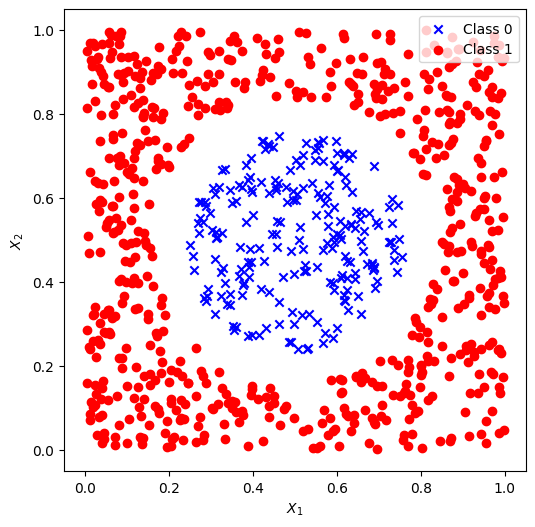

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

def generate_data(num_points):
    data = []
    labels = []

    circle_center = (0.5, 0.5)
    circle_radius = 0.3
    epsilon = 0.04

    for _ in range(num_points):
        x = np.random.rand()
        y = np.random.rand()
        distance = np.sqrt((x - circle_center[0])**2 + (y - circle_center[1])**2)
        if distance <= circle_radius - epsilon or distance>circle_radius+epsilon:
            label = 1 if distance <= 0.3 else 0
            data.append([x, y])
            labels.append(label)
    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)

# Generate training data
num_points = 1000
data, labels = generate_data(num_points)

plt.figure(figsize=(8, 6))

#show colorbar
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], color='blue', marker='x', label='Class 0')
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], color='red', marker='o', label='Class 1')

plt.xlabel(r'$X_1$',fontsize=10)
plt.ylabel(r'$X_2$',fontsize=10)

plt.legend(loc='upper right')

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()



In order to train our network, we still need to implement the loss function. This function needs to return a forward value and a gradient that will be the input to the backward method of the layers of our network.
In this case we use cross entropy loss defined as
$$
\text{CE}(y,\hat y\,\, )=\frac{1}{M}\sum_{i=1}^M -y^{(i)}\log(\hat y^{\,\,(i)}) -(1- y^{(i)})\log(1-\hat y^{\,\,(i)})
$$

****
**Task 3.1:**
Implement the gradient for the cross entropy loss.
****

In [ ]:
def CELoss(y, hat_y):
    """
    Cross entropy error

    Args:
      y: Tensor containing true labels.
      hat_y: Tensor containing predictions.

    Return:
      loss: cross entropy loss.
      grad: gradient of loss w.r.t. hat_y.
    """

    hat_y=hat_y.view(-1)

    loss = torch.mean(-y*torch.log(hat_y) - (1-y)*torch.log(1-hat_y))

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    grad = -y/hat_y + (1-y)/(1-hat_y)
    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    grad = grad.view(-1,1)

    return loss, grad

Now we set all the parameters for the newtork.

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Training parameters
n_epochs = 1000

N_in, hidden_dim, N_out = 2, 64 ,1

lr=0.001

#Define the layers
layers = [Linear(N_in, hidden_dim),
              ReLU(),
              Linear(hidden_dim, N_out),
              Sigmoid()]

#Initialize the network
model = Net(layers)

x = torch.tensor(data)
y = torch.tensor(labels)

# Lists to store training loss and accuracy for plotting
train_losses = []
accuracies = []


****
**Task 3.2:** Complete the missing part of the training loop: calculate the cross entropy loss and append it to the `train_losses` list; perform the backward pass and the update step.
****

Epoch: 0; Loss: 0.56462723; Accuracy: 0.69354839
Epoch: 100; Loss: 0.12152326; Accuracy: 0.99423963
Epoch: 200; Loss: 0.06753320; Accuracy: 1.00000000
Epoch: 300; Loss: 0.04673826; Accuracy: 1.00000000
Epoch: 400; Loss: 0.03536410; Accuracy: 1.00000000
Epoch: 500; Loss: 0.02810933; Accuracy: 1.00000000
Epoch: 600; Loss: 0.02323577; Accuracy: 1.00000000
Epoch: 700; Loss: 0.01964092; Accuracy: 1.00000000
Epoch: 800; Loss: 0.01685330; Accuracy: 1.00000000
Epoch: 900; Loss: 0.01478381; Accuracy: 1.00000000


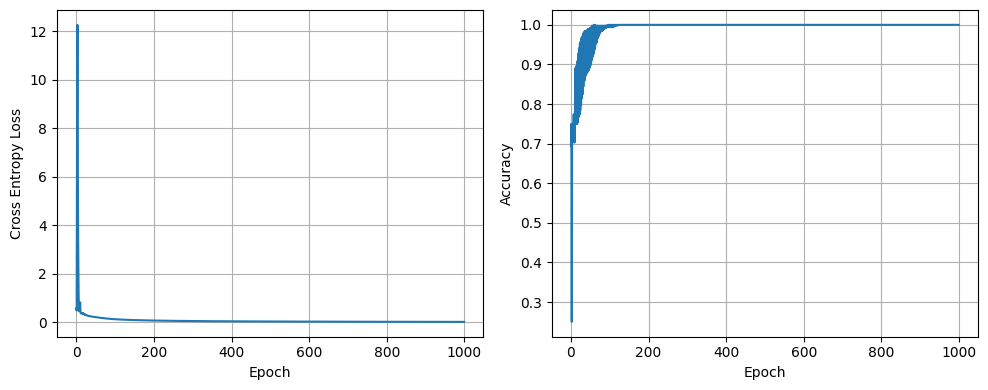

In [ ]:
for epoch in range(n_epochs):

  # Perform the forward pass
  hat_y = model.forward(x)

  ########################################################################
  #                        START OF YOUR CODE                            #
  ########################################################################
  loss, grad = CELoss(y, hat_y)

  train_losses.append(loss)

  dx = model.backward(grad)

  model.update(lr)
  ########################################################################
  #                          END OF YOUR CODE                            #
  ########################################################################

  hat = (hat_y>= 0.5).int().view(hat_y.shape[0])
  accuracy = torch.sum(hat == y).item() / len(y)
  accuracies.append(accuracy)

  if epoch%100==0:
    print(f'Epoch: {epoch}; Loss: {loss:.8f}; Accuracy: {accuracy:.8f}')

#plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(train_losses, label='training loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.grid()
plt.show()

If everything went well you should have obtained accuracy close to 1 after few hundreds of epochs.

****
**Question 3.3:**
How did we compute the accuracy? What does the network output `hat_y` represent?

<font color='green'> Write your answere here</font>
****

You can also verify the results of your classifier by having a look at the contour plots below.

<ipython-input-86-a0d90354c555>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.get_cmap('jet').reversed(), alpha=0.5)


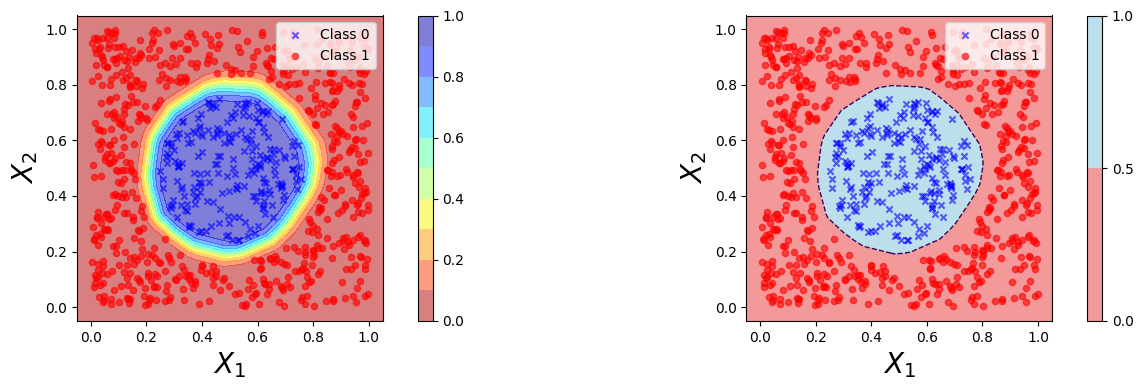

In [ ]:
# Create a grid of points
x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict the labels for each point in the grid
with torch.no_grad():
    input_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model.forward(input_data).numpy().reshape(xx.shape)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.contourf(xx, yy, Z, levels=10, cmap=plt.cm.get_cmap('jet').reversed(), alpha=0.5)

#show colorbar
plt.colorbar()
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], s=20,color='blue', marker='x', label='Class 0',alpha=0.6)
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], s=20,color='red', marker='o', label='Class 1',alpha=0.6)

plt.xlabel(r'$X_1$',fontsize=20)
plt.ylabel(r'$X_2$',fontsize=20)
plt.legend(loc='upper right')

# Set equal aspect ratio
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.gca().set_aspect('equal', adjustable='box')


plt.subplot(1,2,2)
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['lightcoral', 'lightblue'], alpha=0.8)

#show colorbar
plt.colorbar()

# Plot the training data points within the figure
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], s=20, color='blue', marker='x', label='Class 0',alpha=0.6)
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], s=20, color='red', marker='o', label='Class 1', alpha=0.6)

plt.contour(xx, yy, Z, levels=[0.5], linewidths=1, linestyles='dashed', alpha=1)

plt.xlabel(r'$X_1$',fontsize=20)
plt.ylabel(r'$X_2$',fontsize=20)
plt.legend(loc='upper right')

# Set equal aspect ratio
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

****
**Question 3.4:** Set the hidden dimension to 4 or 2 and re-train the network. What happens if we use a much smaller network? How comes that the accuracy is still pretty high?


<font color='green'> Write your answere here </font>
****

# 4 Revisiting the Gaussian regression problem

In this last section we revisit the regression problem introduced in the previous lab. We will then solve it by training a PyTorch network.

Our data are generated according to the 2-dimensional Gaussian ditribution

$$
f(x_1, x_2)=\frac{1}{2 \pi \sigma^2} e^{-\left[\left(x_1-\mu_1\right)^2+\left(x_2-\mu_2\right)^2\right] /\left(2 \sigma^2\right)}
$$

for $\sigma = 50$, $\mu_{1} = 0$, and $\mu_{2} = 0.0$.

It is a continuous regression problem where given input $(x_1,x_2)\in [-2,2]\times[-2,2]$, we try to approximate the output of the gaussian function $f(x_1,x_2)$.

Let's first generate and plot the data.

In [ ]:
# Define the gaussian distribution function
mu1 = 0.
mu2 = 0.
sigma = 10
mean = [mu1, mu2]
cov = [[sigma, 0.0], [0.0, sigma]]
var = multivariate_normal(mean=mean, cov=cov)

# Number of grid points per axis
num_sample_points = 50

# Generate range of x and y values
x1_range = np.linspace(-2, 2., num_sample_points)
x2_range = np.linspace(-2, 2., num_sample_points)

# Generate grid coordinates that will be used to evaluate the gaussian on
x1_nodes, x2_nodes = np.meshgrid(x1_range, x2_range)
nodes = np.column_stack((x1_nodes.ravel(), x2_nodes.ravel()))

# Compute the function over the grid coordinates and store the values
ground_truth = np.zeros(len(nodes), dtype=np.float32)
for i, node in enumerate(nodes):
  gauss_value = var.pdf(node)
  ground_truth[i] = gauss_value

# Convert to numpy matrix to tensor
x = torch.Tensor(nodes)
ground_truth = torch.Tensor(ground_truth)
y = ground_truth.view(ground_truth.shape[0],1)

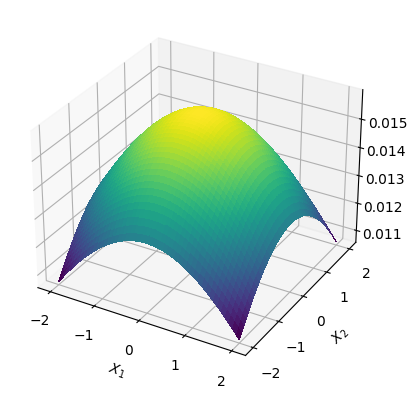

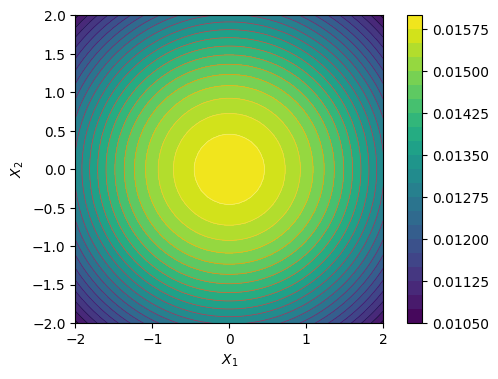

In [ ]:
def plot_result_surface(x_nodes, y_nodes, z_values):
  if isinstance(z_values, torch.Tensor):
    z_values = z_values.detach().numpy()


  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

  # Plot the surface.
  surf = ax.plot_surface(x_nodes, y_nodes, np.reshape(z_values, x_nodes.shape), cmap='viridis',
                        linewidth=0, antialiased=False)
  plt.xlabel(r'$X_1$')
  plt.ylabel(r'$X_2$')
  plt.show()

  z_values = np.reshape(z_values, x_nodes.shape)

  plt.figure(figsize=(6, 4))
  plt.contourf(x_nodes, y_nodes, z_values, levels=20, cmap='viridis')
  plt.colorbar()
  plt.contour(x_nodes, y_nodes, z_values, levels=20, cmap='inferno', linewidths=0.5)
  plt.xlabel(r'$X_1$')
  plt.ylabel(r'$X_2$')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.show()

plot_result_surface(x1_nodes, x2_nodes, ground_truth)

****
**Task 4.1:**
Write a network class with one hidden layer and a ReLU activation and an output layer (use `nn.ReLU` and `nn.Linear`)
****

In [ ]:
class  ModelTorch (nn.Module):
  """
  PyTorch neural network. Network layers are defined in __init__ and forward
  pass implemented in forward.

  Args:
      N_in: number of features/dimensions of input layer
      hidden_dim: number of features/dimensions of hidden dimension
      N_out: number of features/dimensions of output layer
  """

  def __init__(self, N_in, hidden_dim, N_out):

    super(ModelTorch, self).__init__()

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    self.layer1 = nn.Linear(N_in, hidden_dim)
    self.layer2 = nn.ReLU()
    self.layer3 = nn.Linear(hidden_dim, N_out)
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################


  def forward(self, x):

    ########################################################################
    #                        START OF YOUR CODE                            #
    ########################################################################
    y = x
    y = self.layer1(y)
    y = self.layer2(y)
    y = self.layer3(y)
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return y

****
**Task 4.2:**
Fill in the missing parts to train the newtork. First, initialize the network and define an appropriate loss from the options available in the `nn` module [here](https://pytorch.org/docs/stable/nn.html#loss-functions). Next, implement batch gradient descent, execute forward pass and compute the gradients with `.backward()`. Calculate the epoch loss and append it to the `train_losses` list.
****

Epoch [1/5000], Loss: 0.09384236
Epoch [1000/5000], Loss: 0.00007293
Epoch [2000/5000], Loss: 0.00001301
Epoch [3000/5000], Loss: 0.00000394
Epoch [4000/5000], Loss: 0.00000461
Epoch [5000/5000], Loss: 0.00000241


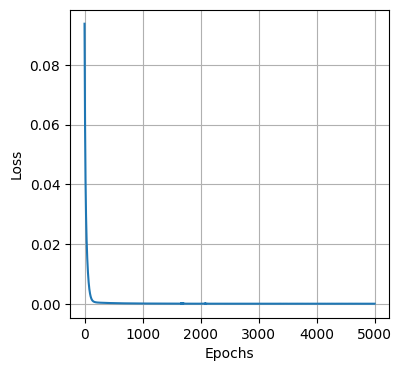

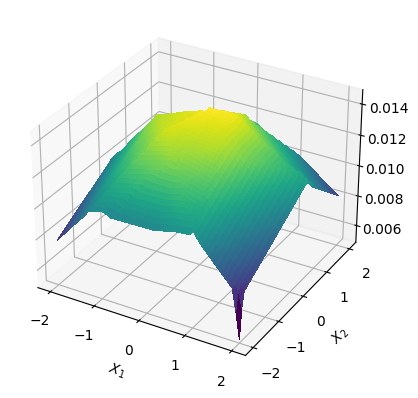

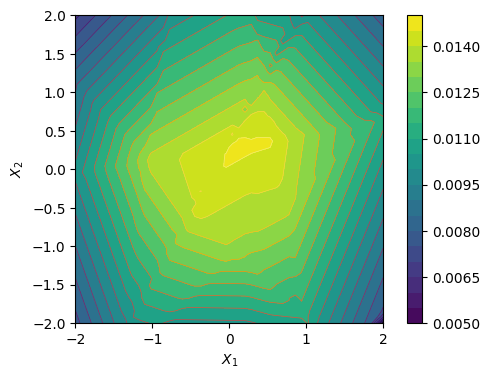

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Training parameters
n_epochs = 5000
lr = 0.0005

#Dimension
M, N_in, hidden_dim, N_out = 1000, 2, 16,1

# List to store training loss
train_losses = []

########################################################################
#                        START OF YOUR CODE                            #
#               Initialize the network and the loss criterion          #
########################################################################
model = ModelTorch(N_in, hidden_dim, N_out)

criterion = nn.MSELoss()
########################################################################
#                         END OF YOUR CODE                             #
########################################################################

optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):

    optimizer.zero_grad()

    epoch_train_loss = 0.0

    for i in range(0, len(x), M):
        ########################################################################
        #                        START OF YOUR CODE                            #
        #        Implement batch GD, perform forward and backward pass         #
        #                    (careful with dimensions!)                        #
        ########################################################################
        batch_x = x[i:i+M]
        batch_y = y[i:i+M].view(-1, 1)

        hat_y_batch = model(batch_x)
        loss = criterion(hat_y_batch, batch_y)
        loss.backward()
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        optimizer.step()
        epoch_train_loss += loss.item()

    ########################################################################
    #                        START OF YOUR CODE                            #
    #               Compute epoch_train_loss and store it                  #
    ########################################################################
    epoch_train_loss /= len(x) /M
    train_losses.append(epoch_train_loss)
    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    if epoch  == 0 or (epoch +1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_train_loss:.8f}')

# Get predictions from the trained model
with torch.no_grad():
    hat_y = model(x).numpy()

#plot loss
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()


# Plot the network's prediction
plot_result_surface(x1_nodes, x2_nodes, hat_y)


If the training steps have been correctly implemented, you should achieve a final training loss on the order of $10^{-6}$, and the contour plot should resemble the one generated for the Gaussian traget function above.

**That's all for this lab, see you in the next one!**